# Blob segmentation and analysis

A common use case for image processing in the biology context is counting blobs of high signal intensity surrounded by a low intensity background. Thresholding is the method of choice in this scenario. We demonstrate it with Otsu's thresholding method (_Otsu et al., IEEE Transactions on Systems, Man, and Cybernetics, Vol. 9 (1), 1979_).

In [ ]:
import pyclesperanto as cle
import numpy as np
import pandas as pd

from skimage import io
from matplotlib import pyplot as plt

In [ ]:
# load data
image = io.imread('https://samples.fiji.sc/blobs.png').squeeze()
print("Image size: ", image.shape)

Image size:  (254, 256)


Thresholding will return a binary image. It is important, to avoid to include noises or to have incomplete structure from the threshold operation, to apply a denoising operation before. 
Once denoised, we can apply an automatic threshold algorithm (_Otsu_) to binarise the image. Finaly, we can run the connected component labeling to generate a label map, where each isolated element of an image is identify with a label `id`.

array([[ 41.42875 ,  34.69644 ,  27.733936, ..., 220.92714 , 211.21162 ,
        206.71573 ],
       [ 47.421425,  38.878723,  30.323011, ..., 228.32323 , 220.60194 ,
        216.83534 ],
       [ 48.121433,  40.610855,  33.357384, ..., 235.32935 , 229.7049  ,
        226.8882  ],
       ...,
       [ 74.4386  ,  76.32904 ,  77.03725 , ...,  48.00032 ,  48.00075 ,
         48.001007],
       [ 81.793655,  81.17787 ,  79.80763 , ...,  48.      ,  48.      ,
         48.      ],
       [ 88.816925,  85.382095,  81.478806, ...,  48.      ,  48.      ,
         48.      ]], dtype=float32, mtype=buffer)
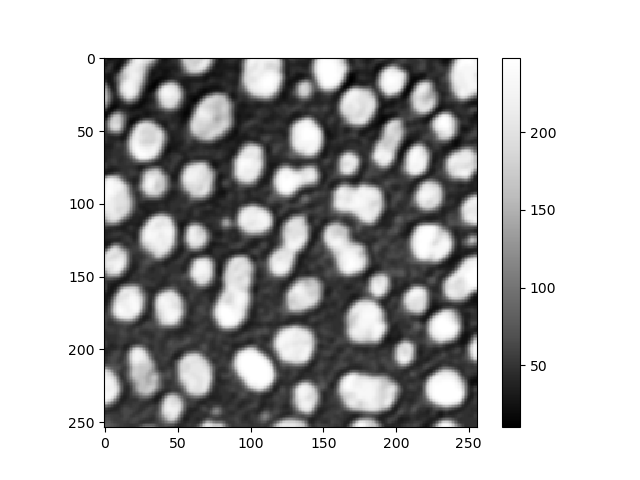
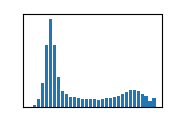

In [ ]:
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)
blurred

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8, mtype=buffer)
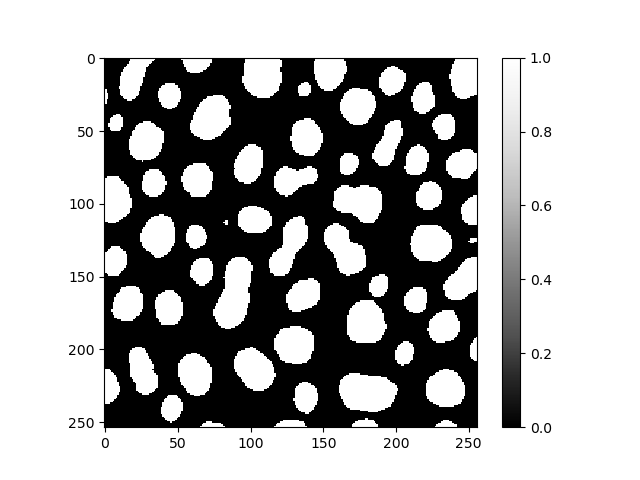
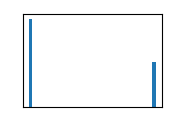

In [ ]:
binary = cle.threshold_otsu(blurred)
binary

array([[0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32, mtype=buffer)
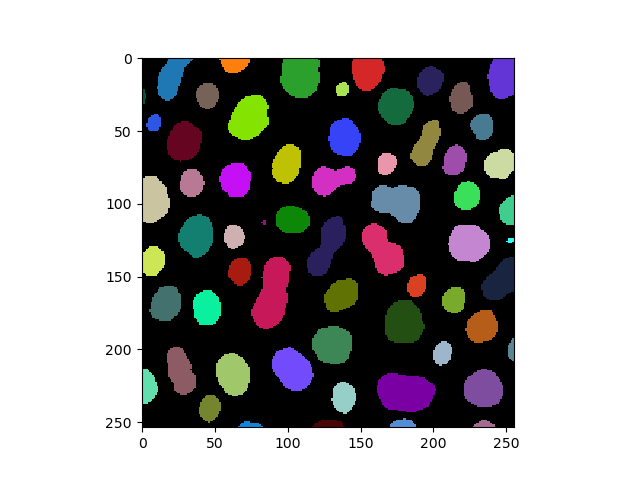

In [ ]:
labeled = cle.connected_components_labeling(binary)
labeled

In [ ]:
# The maximium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled)
print("Number of objects in the image: " + str(num_labels))

Number of objects in the image: 62.0


We can quickly count the number of object segmented by looking at the highest label value. Here, the highest label is 62, which is the number of object detected in the image.

Before rushing to the measurement of object, it is can be important to curate the segmentation to avoid possible analysis bias. For example, in case the size of the objects is relevant, one should exclude the object which were not fully imaged and thus, touch the image border. This operation will reduce the number of object detect, but insure that the object we have are properly segmented.

Once satisfied with the segmentation, certain measurement of the segmented object can be computed for the analysis.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32, mtype=buffer)
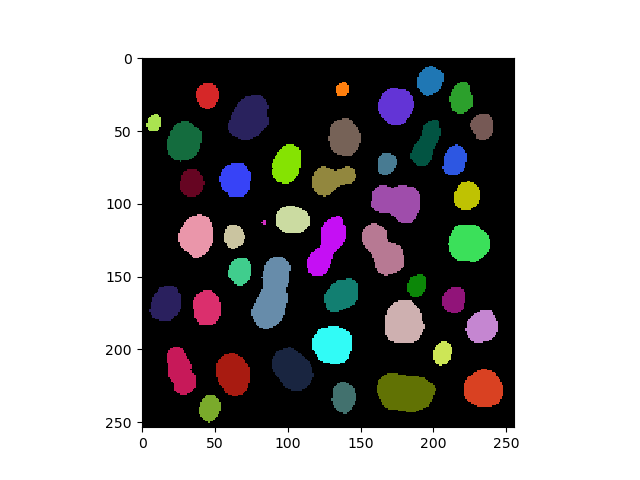

In [ ]:
# Exclude Labels On Edges
labels_excl_edges = cle.exclude_labels_on_edges(labeled)
labels_excl_edges

In [ ]:
df = pd.DataFrame(
    cle.statistics_of_labelled_pixels(image, labels_excl_edges)
    )
df.head()

,max_distance_to_mass_center,mean_distance_to_centroid,mean_distance_to_mass_center,sum_distance_to_centroid,centroid_y,max_distance_to_centroid,sum_y,centroid_x,mass_center_z,mass_center_y,...,sum_distance_to_mass_center,bbox_depth,bbox_max_y,centroid_z,bbox_max_z,bbox_max_x,bbox_min_z,bbox_min_y,bbox_min_x,label
0,10.446603,6.328997,6.328996,1772.119019,15.803572,10.456558,4425.0,197.317856,0.0,15.809253,...,1772.118774,1.0,26.0,0.0,0.0,206.0,0.0,6.0,189.0,1.0
1,5.240184,3.265794,3.265909,244.934540,21.759998,5.248453,1632.0,137.093323,0.0,21.749187,...,244.943207,1.0,26.0,0.0,0.0,141.0,0.0,17.0,133.0,2.0
2,11.283053,6.356250,6.356788,1722.543823,27.778599,11.267818,7528.0,218.715866,0.0,27.765594,...,1722.689575,1.0,38.0,0.0,0.0,226.0,0.0,17.0,211.0,3.0
3,9.204876,5.690794,5.692322,1291.810181,26.083700,9.053935,5921.0,44.572685,0.0,25.920603,...,1292.157227,1.0,35.0,0.0,0.0,52.0,0.0,18.0,37.0,4.0
4,13.331514,8.381179,8.381870,4140.302246,33.176113,13.187855,16389.0,173.923080,0.0,33.045002,...,4140.644043,1.0,46.0,0.0,0.0,186.0,0.0,21.0,162.0,5.0


The function `cle.statistics_of_labelled_pixels` will extract a list of primary measurement, such as object area, centroids, bounding box, etc. A few thing to know on the function:
- most measurement unit are in pixels, pyclesperanto does not take in account data calibration in its computation
- not all measurement are available, if we compare with some other library with similar function (e.g. scikit-image) some measurement cannot be computed by GPU

With such measurement it is possible to isolate specific object like the smallest or biggest structure in the image.

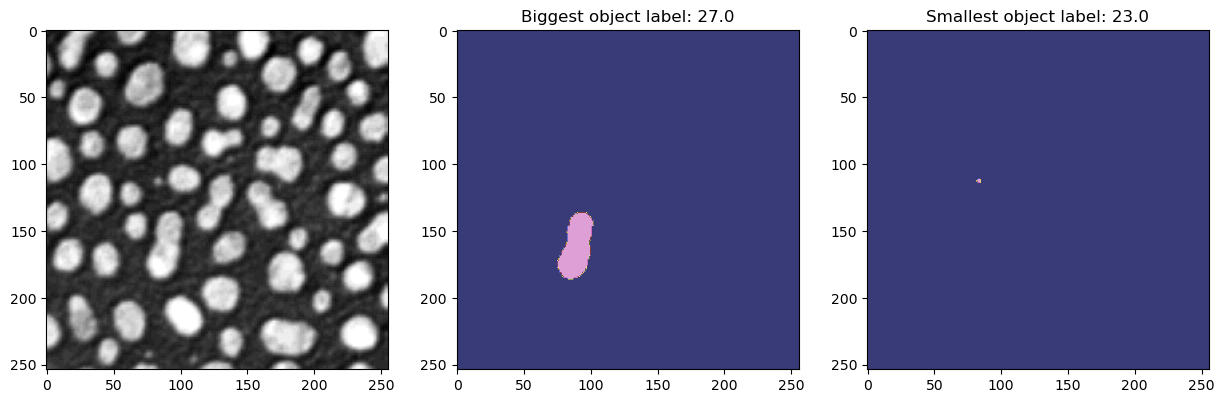

In [ ]:
# get the label with the largest area from the df 
largest_label = df.loc[df['area'].idxmax()]['label']
smalest_label = df.loc[df['area'].idxmin()]['label']

biggest = cle.equal_constant(labels_excl_edges, scalar=largest_label)
smallest = cle.equal_constant(labels_excl_edges, scalar=smalest_label)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(biggest, cmap='tab20b')
axs[1].set_title('Biggest object label: ' + str(largest_label))
axs[2].imshow(smallest, cmap='tab20b')
axs[2].set_title('Smallest object label: ' + str(smalest_label))
plt.show()